In [1]:
import torch
import matplotlib.pyplot as plt

import math
from torch.nn.functional import conv1d
from torch.nn.functional import pad
from torch.autograd import grad

from utils import fft_conv

plt.rcParams.update({'font.size': 16})
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = [4, 2]

## State Spaces

In [2]:
# define signal
L = 100
x = torch.linspace(0, 2*torch.pi, L)
freq = 5
u = torch.sin(freq * x)
u.requires_grad = True


In [3]:
# define simple diagonal state space
# seed all
torch.manual_seed(0)

# we fill this diagonal state matrix with values  (-1, 0) for stability (and convergence speed) reasons (diagonal Hurwitz)
d = 10
A = torch.diag_embed(torch.clamp(torch.randn(d), -0.9, -0.5))
B = torch.ones(d) / 10
C = torch.ones(d)
D = torch.ones(1)

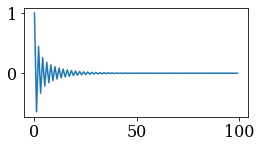

In [4]:
h = torch.tensor([B@ torch.matrix_power(A, k)@C for k in range(100)])

plt.plot(h)

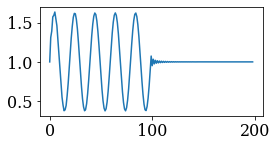

In [5]:
# see definition of the kernel in the notes to check why the "bias / passthrough" term is added here.
y = fft_conv(u, h) + D 

plt.plot(y.detach())

We have obtained a length `L` convolutional kernel without representing it directly as `L` values of $h$. A prototypical example of 
an implicit parametrization! In particular, we only require `10 + 10 + 10 + 1 = 31` instead of `100`. To perform the convolution, we use FFTs as shown previously.

One advantage of implicit parametrizations of convolutions via state spaces is that it gives us a way to extend the kernel to the full signal length `L` without requiring $\mathcal{O}(L)$ values. By structuring `A` appropriately we can further shape the resulting kernel.

What about causality? As we know by now, causality is easy if the convolution is computed via the FFT -- as long as we are careful about our padding!

In [6]:
dydu = torch.zeros(L, L)
for n in range(L):
    dydu[n] = grad(y[n], u, retain_graph=True)[0]

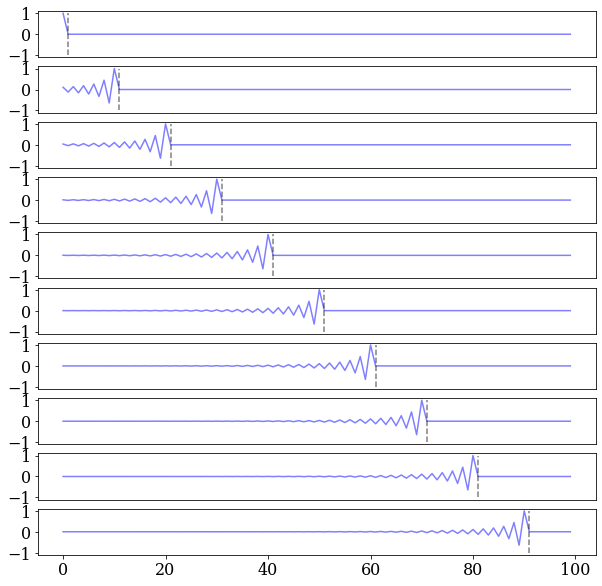

In [7]:
fig, axs = plt.subplots(10, 1, figsize=(10, 10))
for k in range(10): 
    axs[k].plot(dydu[10*k].detach(), c='blue', alpha=0.5)
    axs[k].vlines(10*k + 1, -1, 1, color='black', alpha=0.5, linestyle='--')
    if k < 9: axs[k].set_xticks([])

The memory or effective length of the kernel is related to the convergence of the system $(A, B, C, D)$ to steady-state. If the system is not stable, we encounter numerical issues. Consider the following:

In [8]:
# define simple diagonal state space
# seed all
torch.manual_seed(0)

d = 10
A = torch.diag_embed(torch.ones(d) + 0.05)
B = torch.ones(d) /d
C = torch.ones(d) 
D = torch.ones(1)

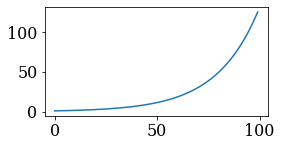

In [9]:
h = torch.tensor([B@ torch.matrix_power(A, k)@C for k in range(100)])

plt.plot(h)

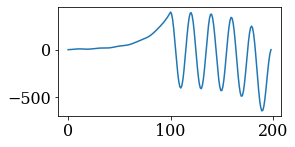

In [10]:
y = fft_conv(u, h) + D 

plt.plot(y.detach())

In [11]:
dydu = torch.zeros(L, L)
for n in range(L):
    dydu[n] = grad(y[n], u, retain_graph=True)[0]

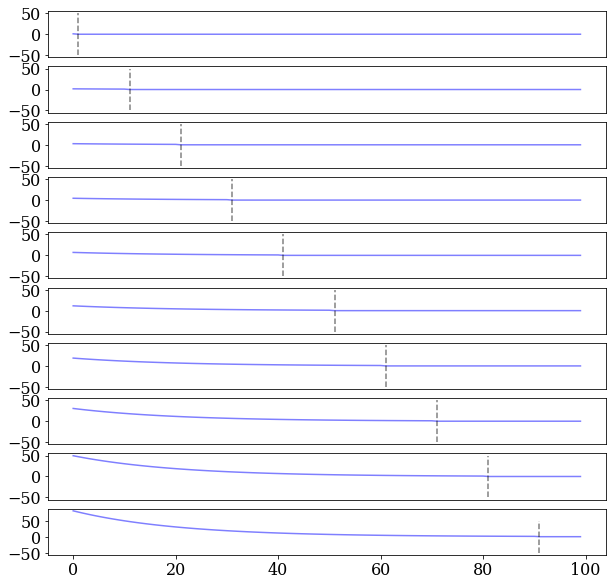

In [12]:
fig, axs = plt.subplots(10, 1, figsize=(10, 10))
for k in range(10): 
    axs[k].plot(dydu[10*k].detach(), c='blue', alpha=0.5)
    axs[k].vlines(10*k + 1, -50, 50, color='black', alpha=0.5, linestyle='--')
    if k < 9: axs[k].set_xticks([])

We are placing further emphasis to observations that appear far in the past i.e., many steps ago. If we apply this method to longer and longer sequences, we will eventually numerically blow up, as the gradients will exponentially grow.

There are far better choices of $A$, although one can usually get pretty good results by choosing diagonal matrices, and thus restricting 
memory to a sum exponentially decaying terms.

Let us look at another example with a different class of $A$ matrices.

In [13]:
d = 10

A = torch.eye(d) / 2 - 0.8 * torch.tril(torch.ones(d, d)) 
B = torch.ones(d) / d
C = torch.ones(d) 
D = torch.ones(1)



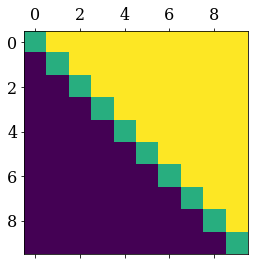

In [14]:
plt.matshow(A)

In [15]:
h = torch.tensor([B@ torch.matrix_power(A, k)@C for k in range(100)])

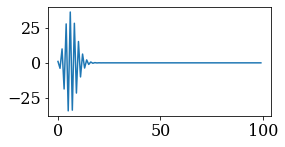

In [16]:
plt.plot(h)

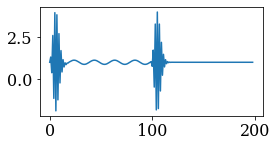

In [17]:
y = fft_conv(u, h) + D 

plt.plot(y.detach())

In [18]:
dydu = torch.zeros(L, L)
for n in range(L):
    dydu[n] = grad(y[n], u, retain_graph=True)[0]

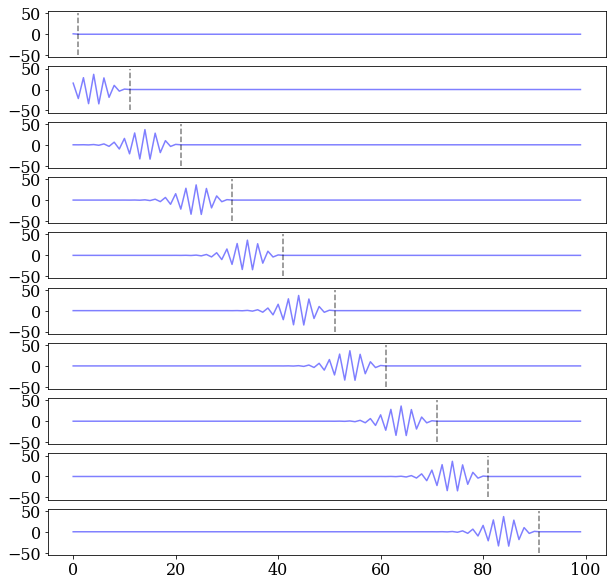

In [19]:
fig, axs = plt.subplots(10, 1, figsize=(10, 10))
for k in range(10): 
    axs[k].plot(dydu[10*k].detach(), c='blue', alpha=0.5)
    axs[k].vlines(10*k + 1, -50, 50, color='black', alpha=0.5, linestyle='--')
    if k < 9: axs[k].set_xticks([])

Interestingly, this choice allows us to focus on points that are neither the most "recent", nor those far into the past.

To summarize, state space implicit parametrizations for convolution kernels:

* Sidestep linear scaling $O(L)$ in the number of parameters for a length $L$ convolution
* Allow us to control and shape the kernel by an appropriate choice of $A$ (and thus corresponding "basis functions"). 

Overall less "flexible" than free-form or explicit parametrizations, which do not introduce any underlying choice of basis functions to compactly represent the convolution kernel.